In [36]:
import torch
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler,TensorDataset
from transformers import  RobertaConfig, RobertaModel, RobertaTokenizer
import argparse
import json
import os
from model2 import Seq2Seq
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler,TensorDataset
import random
import multiprocessing
from tqdm import tqdm, trange
import numpy as np
import javalang
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
np.random.seed(0)
import seaborn as sns
import collections
import pickle
import sklearn
from matplotlib import cm
from sklearn import manifold
from bleu import _bleu
import torch.nn as nn


sns.set_style("darkgrid")
# Pretty colors
BLACK = "k"
GREEN = "#59d98e"
SEA = "#159d82"
BLUE = "#3498db"
PURPLE = "#9b59b6"
GREY = "#95a5a6"
RED = "#e74c3c"
ORANGE = "#f39c12"
YELLOW = "#f1c40f"
GRAY = "#95a5a6"
BROWN = "#8e44ad"
CYAN = "#1abc9c"

In [2]:
class Example(object):
    """A single training/test example."""
    def __init__(self,
                 idx,
                 source,
                 target,
                 ):
        self.idx = idx
        self.source = source
        self.target = target

In [3]:
def read_examples(filename):
    """Read examples from filename."""
    examples=[]
    assert len(filename.split(','))==2
    src_filename = filename.split(',')[0]
    trg_filename = filename.split(',')[1]
    idx = 0
    with open(src_filename) as f1,open(trg_filename) as f2:
            for line1,line2 in zip(f1,f2):
                examples.append(
                Example(
                        idx = idx,
                        source=line1.strip(),
                        target=line2.strip(),
                        )
                )
                idx+=1
    return examples

In [4]:
class InputFeatures(object):
    """A single training/test features for a example."""
    def __init__(self,
                 example_id,
                 source_ids,
                 target_ids,
                 source_mask,
                 target_mask,

    ):
        self.example_id = example_id
        self.source_ids = source_ids
        self.target_ids = target_ids
        self.source_mask = source_mask
        self.target_mask = target_mask 

In [5]:
def convert_examples_to_features(examples, tokenizer, max_source_length, max_target_length, stage=None):
    features = []
    for example_index, example in enumerate(examples):
        #source
        source_tokens = tokenizer.tokenize(example.source)[:max_source_length-2]
        source_tokens =[tokenizer.cls_token]+source_tokens+[tokenizer.sep_token]
        source_ids =  tokenizer.convert_tokens_to_ids(source_tokens) 
        source_mask = [1] * (len(source_tokens))
        padding_length = max_source_length - len(source_ids)
        source_ids+=[tokenizer.pad_token_id]*padding_length
        source_mask+=[0]*padding_length
 
        #target
        if stage=="test":
            target_tokens = tokenizer.tokenize("None")
        else:
            target_tokens = tokenizer.tokenize(example.target)[:max_target_length-2]
        target_tokens = [tokenizer.cls_token]+target_tokens+[tokenizer.sep_token]            
        target_ids = tokenizer.convert_tokens_to_ids(target_tokens)
        target_mask = [1] *len(target_ids)
        padding_length = max_target_length - len(target_ids)
        target_ids+=[tokenizer.pad_token_id]*padding_length
        target_mask+=[0]*padding_length   
   
        if example_index < 5:
            if stage=='train':
                logger.info("*** Example ***")
                logger.info("idx: {}".format(example.idx))

                logger.info("source_tokens: {}".format([x.replace('\u0120','_') for x in source_tokens]))
                logger.info("source_ids: {}".format(' '.join(map(str, source_ids))))
                logger.info("source_mask: {}".format(' '.join(map(str, source_mask))))
                
                logger.info("target_tokens: {}".format([x.replace('\u0120','_') for x in target_tokens]))
                logger.info("target_ids: {}".format(' '.join(map(str, target_ids))))
                logger.info("target_mask: {}".format(' '.join(map(str, target_mask))))
       
        features.append(
            InputFeatures(
                 example_index,
                 source_ids,
                 target_ids,
                 source_mask,
                 target_mask,
            )
        )
    return features

In [6]:
def _truncate_seq_pair(tokens_a, tokens_b,tokens_c, max_length):
    """Truncates a sequence pair in place to the maximum length."""
    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    
    while True:
        total_length = len(tokens_a) + len(tokens_b)+len(tokens_c)
        if total_length <= max_length:
            break
        if len(tokens_a) >= len(tokens_b) and len(tokens_a)>=len(tokens_c):
            tokens_a.pop()
        elif len(tokens_b) >= len(tokens_a) and len(tokens_b)>=len(tokens_c):
            tokens_b.pop()
        else:
            tokens_c.pop()

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = RobertaConfig.from_pretrained('microsoft/codebert-base')

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

encoder = RobertaModel.from_pretrained('microsoft/codebert-base',
                                    output_attentions=True, 
                                    output_hidden_states=True)

decoder_layer = nn.TransformerDecoderLayer(d_model=config.hidden_size, nhead=config.num_attention_heads)
decoder = nn.TransformerDecoder(decoder_layer, num_layers=6)

model=Seq2Seq(encoder=encoder,
              decoder=decoder,
              config=config,
              beam_size=5,
              max_length=512,
              sos_id=tokenizer.cls_token_id,
              eos_id=tokenizer.sep_token_id)

load_model_path = '/home/fjiriges/CodeXGLUE/Code-Code/code-to-code-trans/code/saved_models/model_CR.bin'
model.load_state_dict(torch.load(load_model_path))
model.to(device)

Seq2Seq(
  (encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), e

In [8]:
files=[]
test_filename = '../data/test.java-cs.txt.java,../data/test.java-cs.txt.cs'
files.append(test_filename)

for idx,file in enumerate(files):   
    print("Test file: {}".format(file))
    eval_examples = read_examples(file)
    eval_features = convert_examples_to_features(eval_examples, 
                                                 tokenizer, 
                                                 max_source_length=512,
                                                 max_target_length=512,
                                                 stage='test')
    all_source_ids = torch.tensor([f.source_ids for f in eval_features], dtype=torch.long)
    all_source_mask = torch.tensor([f.source_mask for f in eval_features], dtype=torch.long)    
    eval_data = TensorDataset(all_source_ids,all_source_mask) 

Test file: ../data/test.java-cs.txt.java,../data/test.java-cs.txt.cs


In [9]:
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, 
                             sampler=eval_sampler, 
                             batch_size=1)
model.eval() 
p=[]

In [10]:
len(eval_examples), len(eval_sampler), len(eval_dataloader)

(1000, 1000, 1000)

In [11]:
for example_index, example in enumerate(eval_examples):
    print(example.idx)
    print(example.source)
    print(example.target)  
    break

0
public void serialize(LittleEndianOutput out) {out.writeShort(field_1_vcenter);}
public override void Serialize(ILittleEndianOutput out1){out1.WriteShort(field_1_vcenter);}


In [12]:
def get_syntax_types_for_code(code_snippet):
  types = ["[CLS]"]
  code = ["<s>"]
  tree = list(javalang.tokenizer.tokenize(code_snippet))
  
  for i in tree:
    j = str(i)
    j = j.split(" ")
    if j[1] == '"MASK"':
      types.append('[MASK]')
      code.append('<mask>')
    else:
      types.append(j[0].lower())
      code.append(j[1][1:-1])
    
  types.append("[SEP]")
  code.append("</s>")
  return np.array(types), ' '.join(code)

In [13]:
def get_start_end_of_token_when_tokenized(code, types, tokenizer):
  reindexed_types = []
  start = 0
  end = 0
  for index, each_token in enumerate(code.split(" ")):
    tokenized_list = tokenizer.tokenize(each_token)
    for i in range(len(tokenized_list)):
      end += 1
    reindexed_types.append((start, end-1))
    start = end
  return reindexed_types

In [ ]:
syntaxList = ['annotation', 'basictype', 'boolean', 
                'decimalinteger', 'identifier', 'keyword',
                'modifier', 'operator', 'separator', 'null',
                'string', 'decimalfloatingpoint']

In [48]:
eval_examples[3].source

'public ObjectId getObjectId() {return objectId;}'

In [49]:
types, rewrote_code = get_syntax_types_for_code(eval_examples[3].source)

In [45]:
rewrote_code

'<s> public void serialize ( LittleEndianOutput out ) { out . writeShort ( field_1_vcenter ) ; } </s>'

In [50]:
start_end = get_start_end_of_token_when_tokenized(rewrote_code, types, tokenizer)

In [51]:
types

array(['[CLS]', 'modifier', 'identifier', 'identifier', 'separator',
       'separator', 'separator', 'keyword', 'identifier', 'separator',
       'separator', '[SEP]'], dtype='<U10')

In [54]:
block_size = 512
data = eval_examples[:100]
all_instances = []
number = 0
for sample in tqdm(data, desc="Samples"):
    Instantce_Result = {}
    for syntaxType in syntaxList:
        Instantce_Result[syntaxType] = []
        
    # try:
        
    # source_tokens = tokenizer.tokenize(sample.source)[:block_size-2]
    # source_tokens =[tokenizer.cls_token]+source_tokens+[tokenizer.sep_token]
    
    types, rewrote_code = get_syntax_types_for_code(sample.source)
    start_end = get_start_end_of_token_when_tokenized(rewrote_code, types, tokenizer)
    
    tokenized_ids = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(rewrote_code))
    
    if len(tokenized_ids) > block_size:
                tokenized_ids = tokenized_ids[:block_size] + [tokenizer.sep_token_id]
                
    padding_length = block_size - len(tokenized_ids)
    tokenized_ids+=[tokenizer.pad_token_id]*padding_length

    source_ids = torch.tensor(tokenized_ids).unsqueeze(0).to(device)

    source_mask = torch.ones(source_ids.shape, dtype=torch.long, device=device)
    outputs, encoder_outputs = model(source_ids=source_ids,source_mask=source_mask)  

    _attention = encoder_outputs.attentions
    for syntaxType in syntaxList:
        attention_weights = [[[] for col in range(12)] for row in range(12)]
        for layer in range(12):
            for head in range(12):
                for each_sep_index in np.where(types==syntaxType)[0]:
                    start_index, end_index = start_end[each_sep_index]
                    interim_value = _attention[layer][0][head][:, start_index:end_index+1].mean().cpu().detach().numpy()
                    if np.isnan(interim_value):
                        pass
                    else: 
                        attention_weights[layer][head].append(interim_value)     
        if np.array(attention_weights).shape[2] != 0:
            Instantce_Result[syntaxType].append(np.array(attention_weights))
            
    all_instances.append(Instantce_Result)

Samples: 100%|██████████| 100/100 [15:38<00:00,  9.38s/it]


In [55]:
len(all_instances)

100

In [56]:
all_instances[0].keys()

dict_keys(['annotation', 'basictype', 'boolean', 'decimalinteger', 'identifier', 'keyword', 'modifier', 'operator', 'separator', 'null', 'string', 'decimalfloatingpoint'])

In [57]:
avg_attns = {}
for syntaxType in syntaxList:
    temp = []
    for instance in all_instances:
        a = np.array(instance[syntaxType])
        if a.shape[0] != 0:
            a = a.squeeze(0)
            a = a.mean(axis=2)
            temp.append(a)
    if len(temp) != 0:
        temp = np.array(temp)
        temp = temp.reshape(temp.shape[1], temp.shape[2], temp.shape[0])
        avg_temp = temp.mean(axis=2)
        avg_attns[syntaxType] = avg_temp

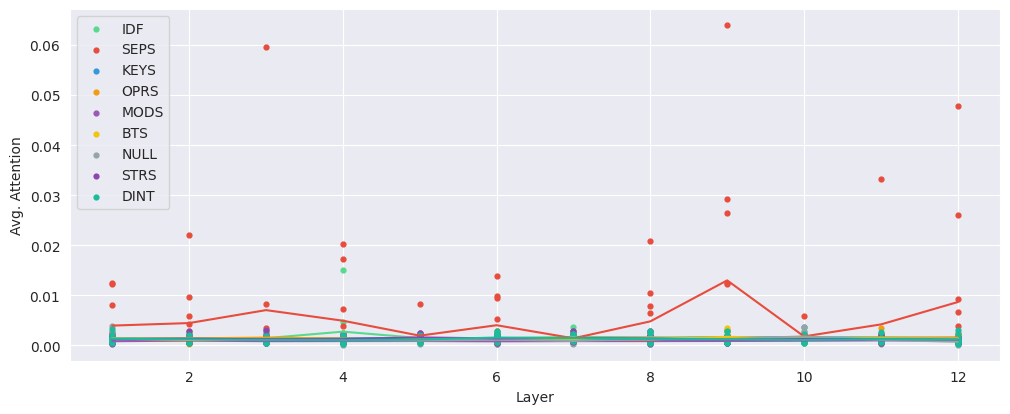

In [59]:
def get_data_points(head_data):
  xs, ys, avgs = [], [], []
  for layer in range(12):
    for head in range(12):
      ys.append(head_data[layer][head])
      xs.append(1 + layer)
    avgs.append(head_data[layer].mean())
  return xs, ys, avgs

def add_line(key, ax, color, label, plot_avgs=True):
  xs, ys, avgs = get_data_points(avg_attns[key])
  ax.scatter(xs, ys, s=12, label=label, color=color)
  if plot_avgs:
    ax.plot(1 + np.arange(len(avgs)), avgs, color=color)
  ax.legend(loc="best")
  ax.set_xlabel("Layer")
  ax.set_ylabel("Avg. Attention")
  

plt.figure(figsize=(12, 21))
ax = plt.subplot(4, 1, 1)
for key, color, label in [("identifier", GREEN, "IDF"),("separator", RED, "SEPS"), ("keyword", BLUE, "KEYS"), ("operator", ORANGE, "OPRS"), ("modifier", PURPLE, "MODS"), ("basictype", YELLOW, "BTS"), ("null", GRAY, "NULL"), ("string", BROWN, "STRS"), ("decimalinteger", CYAN, "DINT")]:
  add_line(key, ax, color, label, plot_avgs=True)